In [1]:
import glob
import uproot
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.rcParams.update({"figure.facecolor": (1,1,1,0)})
import mplhep as hep
plt.style.use(hep.style.CMS)
import yahist
from tqdm import tqdm

from utils.file_info import parse

In [5]:
SIM_VER = "v3"
CEPH_DIR = f"/ceph/cms/store/user/jguiang/VBSWHSignalGeneration/{SIM_VER}"
YEAR = "RunIISummer20UL18"
NEG_FILENAME = f"{CEPH_DIR}/VBSWH_negLambdaWZ_kWkZscan_m2to2_Mjj100toInf_TuneCP5_{YEAR}-106X_privateMC_NANOGEN_{SIM_VER}/merged.root"
POS_FILENAME = f"{CEPH_DIR}/VBSWH_posLambdaWZ_kWkZscan_m2to2_fromBSM_Mjj100toInf_TuneCP5_{YEAR}-106X_privateMC_NANOGEN_{SIM_VER}/merged.root"

In [6]:
with open(f"../analysis/data/VBSWH_negLambda_reweights.txt", "r") as f_in:
    neg_reweight_names = f_in.read().splitlines()
    
with open(f"../analysis/data/VBSWH_posLambda_reweights.txt", "r") as f_in:
    pos_reweight_names = f_in.read().splitlines()

with uproot.open(NEG_FILENAME) as f:
    neg_reweights = np.stack(f["Events"].arrays("LHEReweightingWeight", library="np")["LHEReweightingWeight"])
    neg_reweights = np.insert(neg_reweights, 139, 1, axis=1)
    
with uproot.open(POS_FILENAME) as f:
    pos_reweights = np.stack(f["Events"].arrays("LHEReweightingWeight", library="np")["LHEReweightingWeight"])
#     pos_reweights = np.insert(pos_reweights, 278, 1, axis=1)
    
neg_finfo = parse(NEG_FILENAME, xsecs_json="../analysis/data/xsecs.json")
pos_finfo = parse(NEG_FILENAME, xsecs_json="../analysis/data/xsecs.json")

In [7]:
neg_finfo["xsec_sf"]*np.sum(neg_reweights.T[139])/(1000*neg_finfo["lumi"])

0.437504

In [8]:
# pos_finfo["xsec_sf"]*np.sum(pos_reweights.T[278])/(1000*pos_finfo["lumi"])

In [9]:
kW_points = []
kZ_points = []
xsecs = []
for reweight_i in range(neg_reweights.T.shape[0]):
    neg_name = neg_reweight_names[reweight_i]

    xsec = neg_finfo["xsec_sf"]*np.sum(neg_reweights.T[reweight_i])/(1000*neg_finfo["lumi"])
    xsecs.append(xsec)
    
    kW = float(neg_name.replace("p", ".").replace("m", "-").split("_")[2])
    kZ = float(neg_name.replace("p", ".").replace("m", "-").split("_")[4])
    kW_points.append(kW)
    kZ_points.append(kZ)

for reweight_i in range(pos_reweights.T.shape[0]):
    pos_name = pos_reweight_names[reweight_i]

    xsec = pos_finfo["xsec_sf"]*np.sum(pos_reweights.T[reweight_i])/(1000*pos_finfo["lumi"])
    xsecs.append(xsec)

    kW = float(pos_name.replace("p", ".").replace("m", "-").split("_")[2])
    kZ = float(pos_name.replace("p", ".").replace("m", "-").split("_")[4])
    kW_points.append(kW)
    kZ_points.append(kZ)

In [10]:
kW_values = np.unique(kW_points)
kW_widths = kW_values[1:] - kW_values[:-1]
kW_bin_edges = np.union1d(
    kW_values[:-1] + 0.5*kW_widths,
    kW_values[1:]  - 0.5*kW_widths,
)
kW_bin_edges = np.concatenate((
    [kW_values[0] - 0.5*kW_widths[0]],
    kW_bin_edges,
    [kW_values[-1] + 0.5*kW_widths[-1]]
))

kZ_values = np.unique(kZ_points)
kZ_widths = kZ_values[1:] - kZ_values[:-1]
kZ_bin_edges = np.union1d(
    kZ_values[:-1] + 0.5*kZ_widths,
    kZ_values[1:]  - 0.5*kZ_widths
)
kZ_bin_edges = np.concatenate((
    [kZ_values[0] - 0.5*kZ_widths[0]],
    kZ_bin_edges,
    [kZ_values[-1] + 0.5*kZ_widths[-1]]
))

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as clr

cmap = clr.LinearSegmentedColormap.from_list("trident", ["#182B49","#00629B", "#C69214", "#FFCD00"], N=256)

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    return fig.colorbar(mappable, cax=cax)

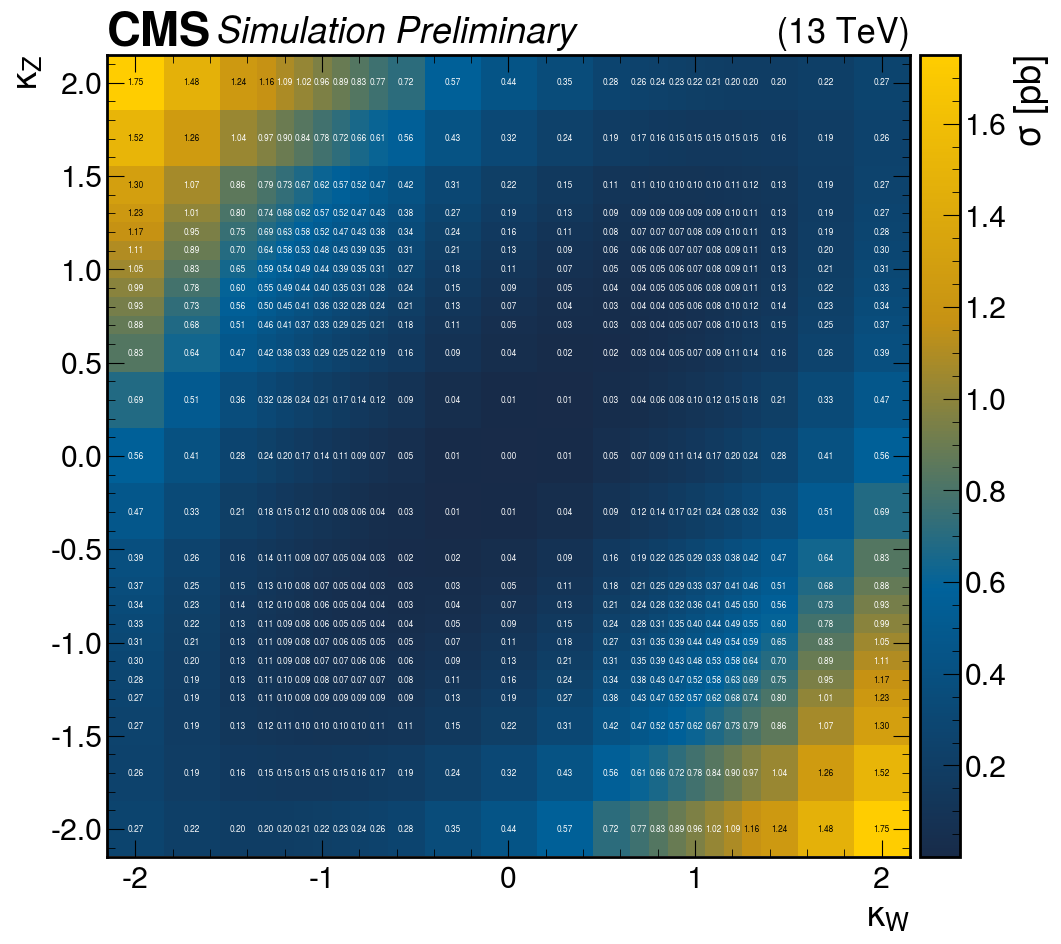

In [12]:
hist2d = yahist.Hist2D(
    (kW_points, kZ_points),
    bins=[kW_bin_edges, kZ_bin_edges],
    weights=np.array(xsecs)
)

# Plot 2D hist
fig, axes = plt.subplots(figsize=(11, 11))
mpl_objs = hist2d.plot(
    ax=axes, colorbar=False, counts=True, counts_formatter="{:.2f}".format, counts_fontsize=6, cmap=cmap
);
axes.set_xlabel(r"$\kappa_W$");
axes.set_ylabel(r"$\kappa_Z$");
axes.set_aspect("equal");

# Plot colorbar
cbar = colorbar(mpl_objs[0]);
cbar.set_label(r"$\sigma$ [pb]");

# Add CMS label
hep.cms.label(
    "Preliminary",
    data=False,
#     lumi=neg_finfo["lumi"],
    loc=0,
    ax=axes,
#     fontsize=24
);

plt.savefig("/home/users/jguiang/public_html/vbswh_plots/reweighting/xsecs_2D.pdf", bbox_inches="tight");

In [13]:
def plot_xsec_slice(kW, kZ, transpose=False):
    global hist2d
    global kW_values
    global kZ_values
    
    parabola = lambda x, A, B: A*x**2 + B
    
    fig, axes = plt.subplots()
    if transpose:
        # Get yields
        sig_yields = hist2d.counts.T[np.where(kW_values == kW)[0][0]]
        # Plot good yields
        axes.scatter(kZ_values[kZ_values != kZ], sig_yields[kZ_values != kZ]);
        # Plot bad yield
        axes.scatter(kZ_values[kZ_values == kZ], sig_yields[kZ_values == kZ]);
        
        # Fit good yields
        opt_params, _ = curve_fit(parabola, kZ_values[kZ_values != kZ], sig_yields[kZ_values != kZ])
        # Plot fit
#         axes.plot(np.linspace(-2, 2, 201), [parabola(x, *opt_params) for x in np.linspace(-2, 2, 201)])
        
        axes.set_xlabel(r"$\kappa_Z$");
        axes.set_title(r"$\kappa_W = NUMBER$".replace("NUMBER", str(kW)));
    else:
        # Get yields
        sig_yields = hist2d.counts[np.where(kZ_values == kZ)[0][0]]
        # Plot good yields
        axes.scatter(kW_values[kW_values != kW], sig_yields[kW_values != kW]);
        # Plot bad yields
        axes.scatter(kW_values[kW_values == kW], sig_yields[kW_values == kW]);

        # Fit good yields
        opt_params, _ = curve_fit(parabola, kW_values[kW_values != kW], sig_yields[kW_values != kW])
        # Plot fit
#         axes.plot(np.linspace(-2, 2, 201), [parabola(x, *opt_params) for x in np.linspace(-2, 2, 201)])
        
        axes.set_xlabel(r"$\kappa_W$");
        axes.set_title(r"$\kappa_Z = NUMBER$".replace("NUMBER", str(kZ)));
        
    axes.set_ylabel(r"$\sigma$ [pb]");

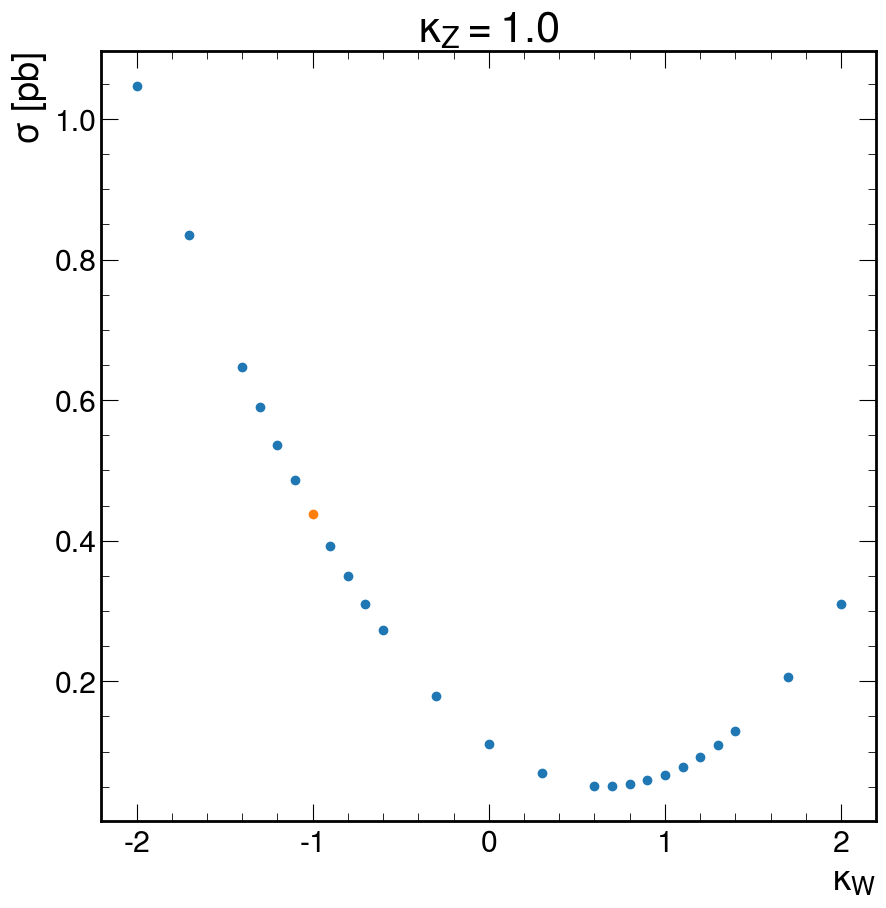

In [14]:
plot_xsec_slice(-1.0, 1.0)

In [15]:
def plot_xsecs(kW_eq_1=False, axes=None):
    if kW_eq_1:
        key = "kW_1p0"
        kappa = r"\kappa_Z"
        fit_guess = [1, 1, 0.145]
    else:
        key = "kZ_1p0"
        kappa = r"\kappa_W"
        fit_guess = [1, 1, 0.108]
    
    kappas = []
    xsecs = []
    for reweight_i in range(neg_reweights.T.shape[0]):
        reweight_name = neg_reweight_names[reweight_i]
        if key not in reweight_name:
            continue

        xsec = neg_finfo["xsec_sf"]*np.sum(neg_reweights.T[reweight_i])/(1000*neg_finfo["lumi"])
        xsecs.append(xsec)
        
        other_key = list(filter(None, reweight_name.replace(key, "").split("_")))[-1]
        kappas.append(float(other_key.replace("m", "-").replace("p", ".")))

    for reweight_i in range(pos_reweights.T.shape[0]):
        reweight_name = pos_reweight_names[reweight_i]
        if key not in reweight_name:
            continue

        xsec = pos_finfo["xsec_sf"]*np.sum(pos_reweights.T[reweight_i])/(1000*pos_finfo["lumi"])
        xsecs.append(xsec)
        
        other_key = list(filter(None, reweight_name.replace(key, "").split("_")))[-1]
        kappas.append(float(other_key.replace("m", "-").replace("p", ".")))
        
    # Perform fit
    parabola = lambda x, A, B, C: A*x**2 + B*x + C
    opt_params, _ = curve_fit(parabola, kappas, xsecs, p0=fit_guess)
    A, B, C = opt_params

    # Plot fit and points
    if axes is None:
        fig, axes = plt.subplots();
        
    axes.plot(
        np.linspace(-3, 3, 31), [parabola(x, A, B, C) for x in np.linspace(-3, 3, 31)], 
#         color="#364b9a",
#         color="lightgrey",
        color="#00629B",
        linestyle="dashed",
        label=(r"$AK^2 BK C$".replace("A", f"{A:0.3f}")
                             .replace("B", f"{B:+0.3f}")
                             .replace("C", f"{C:+0.3f}")
                             .replace("K", kappa))
    );
    axes.scatter(
        kappas, xsecs, 
        marker="o", 
        color="#00629B",
        label=r"Reweighted $\sigma$", 
        zorder=100
    );
    axes.legend();

    # Add CMS label
    hep.cms.label(
        "Preliminary",
        data=False,
#         lumi=neg_finfo["lumi"],
        loc=0,
        ax=axes,
    )

    axes.set_ylim([0, 2]);
    axes.set_xlabel(f"${kappa}$");
    axes.set_ylabel(r"$\sigma$ [pb]");
    
    if kW_eq_1:
        plt.savefig("/home/users/jguiang/public_html/vbswh_plots/reweighting/xsecs_rwgt_kZ.pdf", bbox_inches="tight");
    else:
        plt.savefig("/home/users/jguiang/public_html/vbswh_plots/reweighting/xsecs_rwgt_kW.pdf", bbox_inches="tight");
        
    return (A, B, C)

(0.14175520515378556, -0.1847534174987534, 0.11082043287257658)

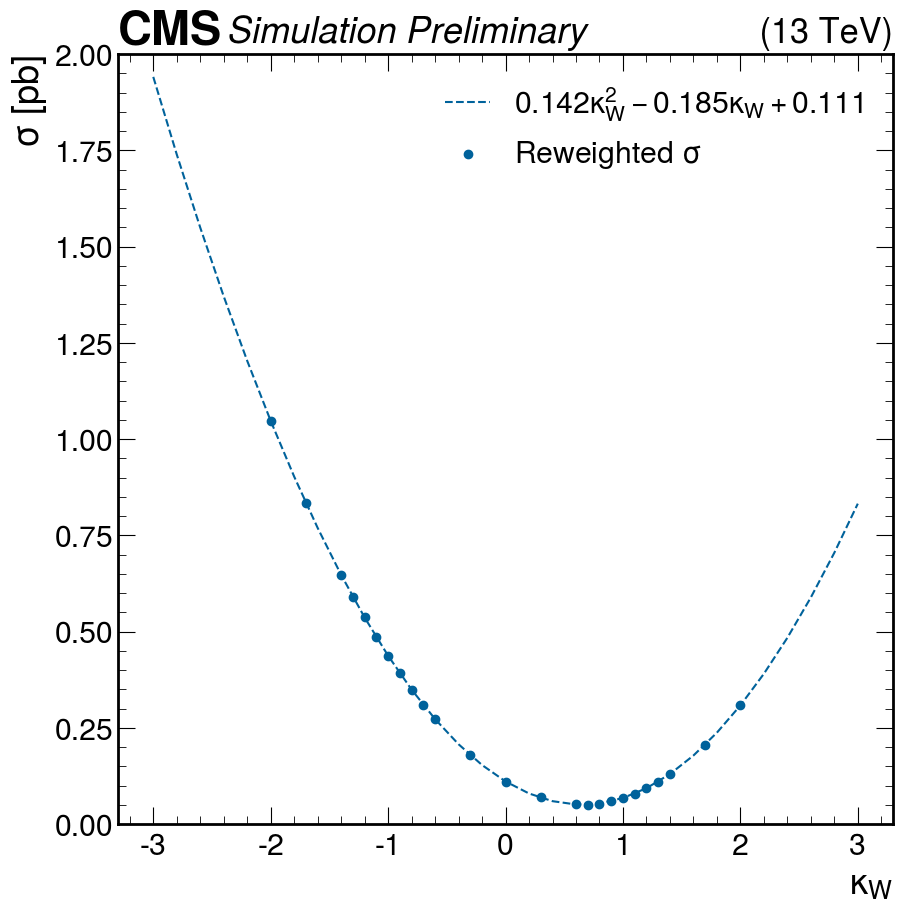

In [16]:
plot_xsecs(kW_eq_1=False)

(0.11107898902643247, -0.18487556211904901, 0.14151407314431916)

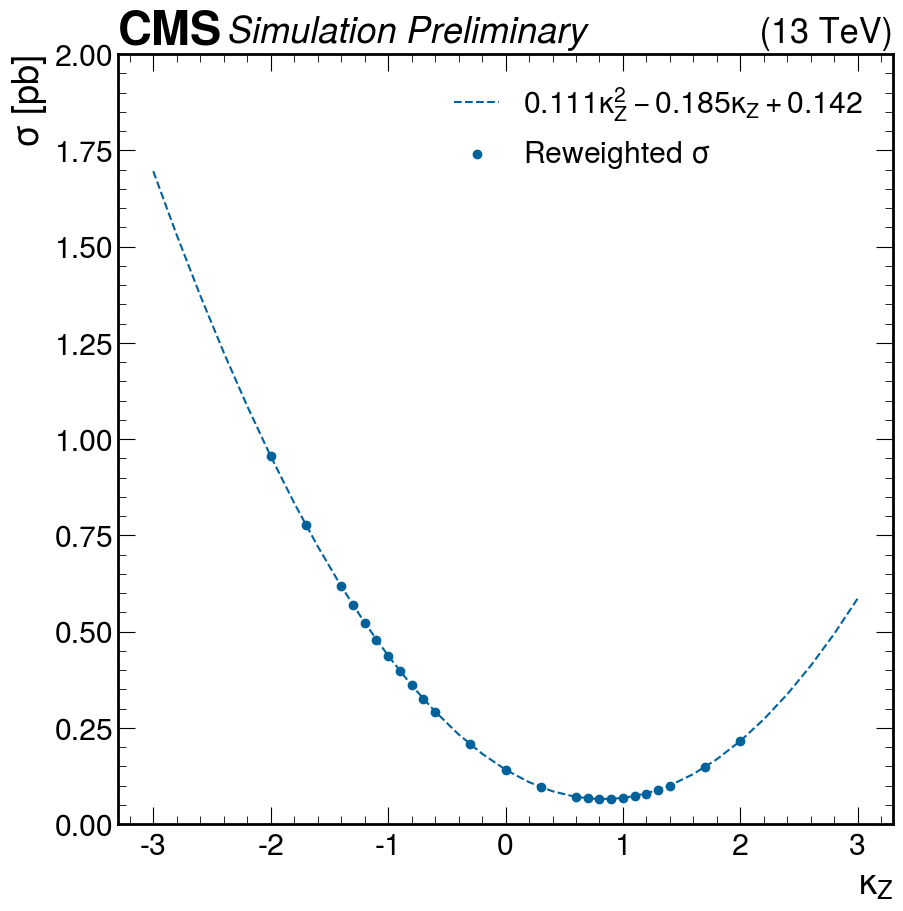

In [17]:
plot_xsecs(kW_eq_1=True)

In [18]:
lumi_inv_fb = 138

def get_lhe_dfs(lhe_files, lumi_invfb=138):
    dfs = []
    xsec_df = []
    kW, kZ = (-999, -999)
    for lhe_file in tqdm(lhe_files):
        name = lhe_file.split("/")[-1].replace(".lhe", "")
        

In [19]:
lumi_inv_fb = 138

def get_lhe_dfs(lhe_babies, lumi_invfb=138):
    dfs = []
    xsec_df = []
    kW, kZ = (-999, -999)
    for lhe_baby in tqdm(lhe_babies):
        name = lhe_baby.split("/")[-1].replace("_Inclusive_4f_LO.root", "")
        if name == "VBSWH":
            kW, kZ = (1, 1)
        elif "VBSWH_kWkZscan" in name:
            continue
        elif name == "VBSWH_kWscan_kZscan_m1p5_to_m0p5":
            continue
        else:
            if "mkW" in name:
                kW, kZ = (-1, 1)
            elif "mkZ" in name:
                kW, kZ = (1, -1)
            else:
                kV = float(name.split("_")[-1].split("k")[0].replace("p", ".").replace("m", "-"))
                if "kW" in name:
                    kW, kZ = (kV, 1)
                elif "kZ" in name:
                    kW, kZ = (1, kV)
        with uproot.open(lhe_baby) as f:
            xsec_pb = f["Processes"].arrays()[0]["XSECUP"]
            xsec_err = f["Processes"].arrays()[0]["XERRUP"]
            
        xsec_df.append({"name": name, "kW": kW, "kZ": kZ, "xsec": xsec_pb, "xsec_err": xsec_err})
        
    return pd.DataFrame(xsec_df)

xsec_df = get_lhe_dfs(glob.glob("/ceph/cms/store/user/jguiang/VBSWHSignalGeneration/lhe/new_vbswh_singlepoint/*.root"))

xsec_df

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.88it/s]


,name,kW,kZ,xsec,xsec_err
0,VBSWH_mkZ,1.0,-1.0,0.440859,0.001395
1,VBSWH,1.0,1.0,0.065707,0.000197
2,VBSWH_m0p1kW,-0.1,1.0,0.133109,0.000471
3,VBSWH_m0p1kZ,1.0,-0.1,0.161420,0.000513
4,VBSWH_m2kZ,1.0,-2.0,0.962744,0.002954
5,VBSWH_0p1kW,0.1,1.0,0.094744,0.000326
6,VBSWH_1p5kW,1.5,1.0,0.148947,0.000476
7,VBSWH_mkW,-1.0,1.0,0.440954,0.001395
8,VBSWH_1p5kZ,1.0,1.5,0.111756,0.000328
9,VBSWH_0p5kW,0.5,1.0,0.053276,0.000179


In [20]:
xsec_df["xsec_percent_err"] = xsec_df.xsec_err/xsec_df.xsec*100

xsec_df

,name,kW,kZ,xsec,xsec_err,xsec_percent_err
0,VBSWH_mkZ,1.0,-1.0,0.440859,0.001395,0.316391
1,VBSWH,1.0,1.0,0.065707,0.000197,0.299815
2,VBSWH_m0p1kW,-0.1,1.0,0.133109,0.000471,0.353892
3,VBSWH_m0p1kZ,1.0,-0.1,0.161420,0.000513,0.317756
4,VBSWH_m2kZ,1.0,-2.0,0.962744,0.002954,0.306858
5,VBSWH_0p1kW,0.1,1.0,0.094744,0.000326,0.344095
6,VBSWH_1p5kW,1.5,1.0,0.148947,0.000476,0.319784
7,VBSWH_mkW,-1.0,1.0,0.440954,0.001395,0.316326
8,VBSWH_1p5kZ,1.0,1.5,0.111756,0.000328,0.293843
9,VBSWH_0p5kW,0.5,1.0,0.053276,0.000179,0.336440


In [21]:
# "#182B49" blue
# "#FFCD00" gold

# "#182B49" dark blue
# "#00629B" blue
# "#C69214" reddish?
# "#FFCD00" gold

def plot_xsecs_overlay(kW_eq_1=False, axes=None):
    if kW_eq_1:
        key = "kW_1p0"
        kappa = r"\kappa_Z"
        fit_guess = [1, 1, 0.145]
    else:
        key = "kZ_1p0"
        kappa = r"\kappa_W"
        fit_guess = [1, 1, 0.108]

    if kW_eq_1:
        kappas = xsec_df[xsec_df.kW == 1].kZ
        xsecs = xsec_df[xsec_df.kW == 1].xsec
    else:
        kappas = xsec_df[xsec_df.kZ == 1].kW
        xsecs = xsec_df[xsec_df.kZ == 1].xsec

    # Perform fit
    parabola = lambda x, A, B, C: A*x**2 + B*x + C
    opt_params, _ = curve_fit(parabola, kappas, xsecs, p0=fit_guess)
    A, B, C = opt_params


    fig = plt.figure()
    gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.08)
    hist_axes = fig.add_subplot(gs[0])
    ratio_axes = fig.add_subplot(gs[1])

    rwgt_fit = plot_xsecs(kW_eq_1=kW_eq_1, axes=hist_axes)

    hist_axes.plot(
        np.linspace(-3, 3, 31), [parabola(x, A, B, C) for x in np.linspace(-3, 3, 31)], 
#         color="grey",
        color="#FFCD00",
        linestyle="dotted",
        label=(r"$AK^2 BK C$".replace("A", f"{A:0.3f}")
                             .replace("B", f"{B:+0.3f}")
                             .replace("C", f"{C:+0.3f}")
                             .replace("K", kappa))
    );

    hist_axes.scatter(
        kappas, 
        xsecs, 
        label=r"Single-point $\sigma$",
        color="#FFCD00",
        marker="s",
        zorder=99
    );
    
    ratio_axes.plot(
        np.linspace(-3, 3, 31), 
        [parabola(x, A, B, C)/parabola(x, *rwgt_fit) for x in np.linspace(-3, 3, 31)], 
        color="grey"
    )
    ratio_axes.scatter(
        kappas, [xsec/parabola(k, *rwgt_fit) for xsec, k in zip(xsecs, kappas)],
        color="grey", marker="s"
    )

    hist_axes.legend();
    hist_axes.set_xticklabels([]);
    hist_axes.set_xlabel("");
    ratio_axes.axhline(y=1, color="k", linestyle="--", alpha=0.75, linewidth=0.75);
#     ratio_axes.legend().remove();
    ratio_axes.set_ylabel("single/rwgt");
    if kW_eq_1:
        hist_axes.text(-3, 0.1, r"$\kappa_W = 1$")
        ratio_axes.set_xlabel("$\kappa_Z$");
    else:
        hist_axes.text(-3, 0.1, r"$\kappa_Z = 1$")
        ratio_axes.set_xlabel("$\kappa_W$");
#     ratio_axes.set_ylim([0.5, 1.5]);
#     ratio_axes.set_ylim([0.8, 1.2]);
    ratio_axes.set_ylim([0.95, 1.05])
    
    if kW_eq_1:
        plt.savefig("/home/users/jguiang/public_html/vbswh_plots/reweighting/xsec_check_kZ.pdf", bbox_inches="tight");
    else:
        plt.savefig("/home/users/jguiang/public_html/vbswh_plots/reweighting/xsec_check_kW.pdf", bbox_inches="tight");

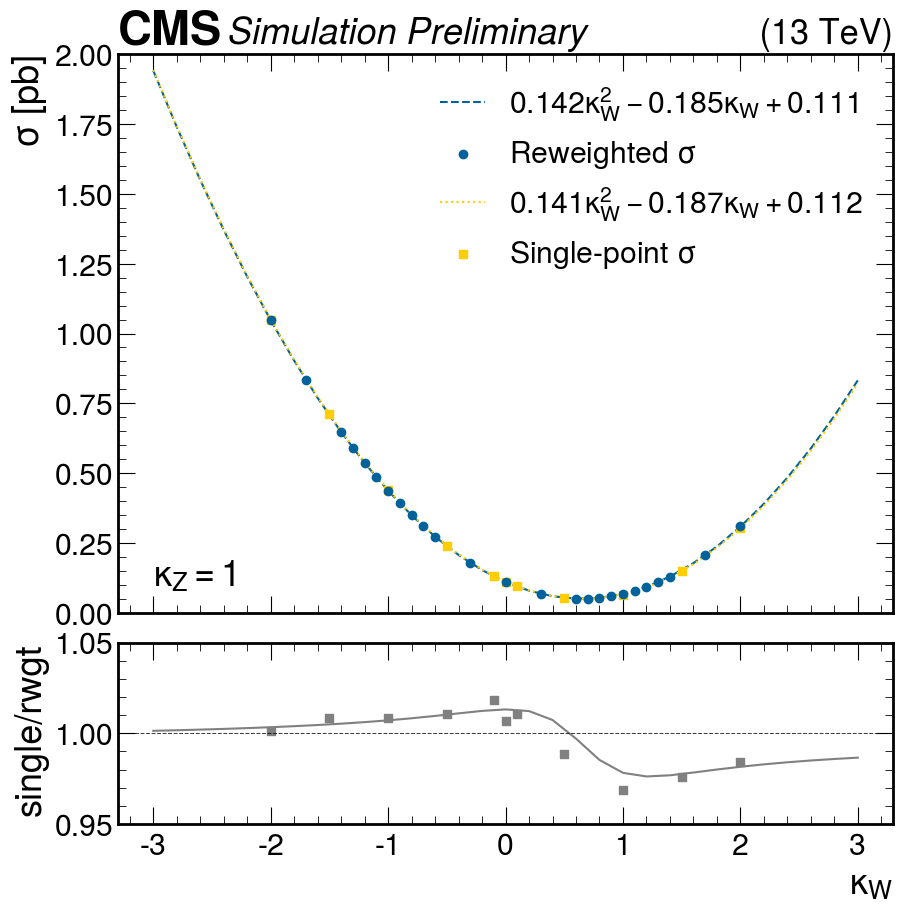

In [22]:
plot_xsecs_overlay(kW_eq_1=False)

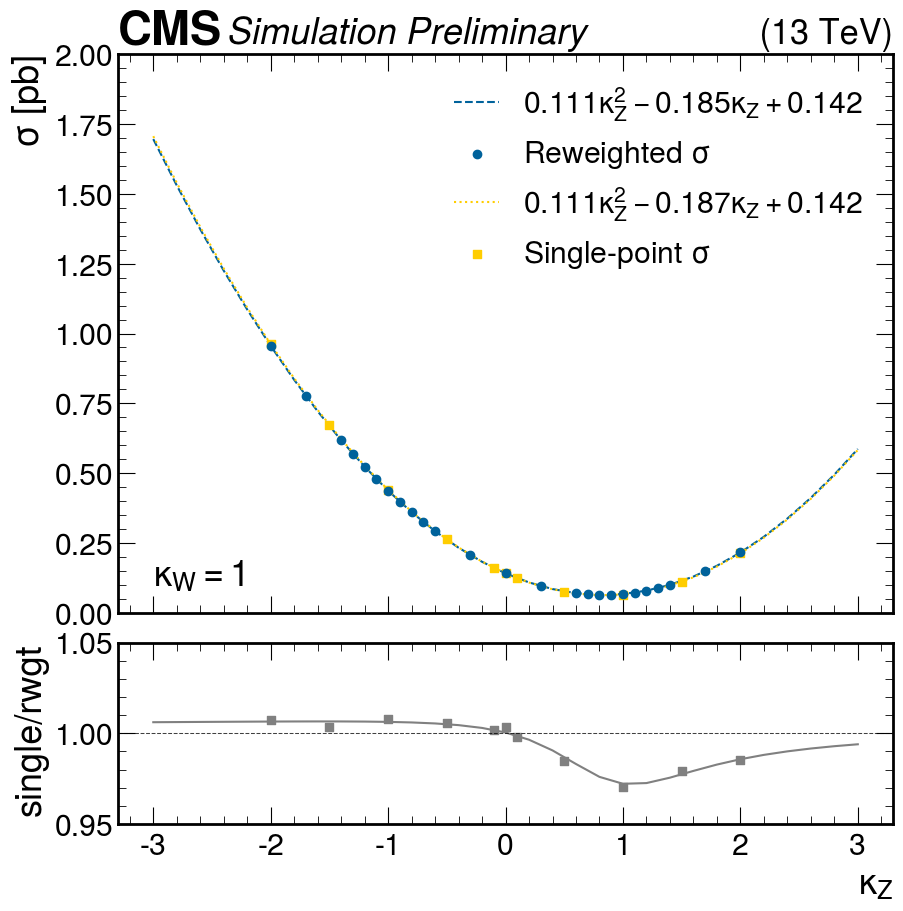

In [23]:
plot_xsecs_overlay(kW_eq_1=True)